# Produce some plots of importation probabilities

Use the analytical formulas from Wallinga and Scalia Tomba


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from tqdm import tqdm
import numpy.linalg as nla
import seaborn as sns
import scipy as sp
import pandas as pd

## Jacob

In [3]:
# =============================================================================
# Class for solving ODEs
# =============================================================================
class ODESolver:
    def __init__(self, f):
        self.f = f
    
    def advance(self):
        raise NotImplementedError
    
    def set_ic(self, u0):
        if not isinstance(u0, float):
            self.u0 = u0.astype(float)
        else:
            self.u0 = u0
    
    def solver(self, time_points):
        self.t = np.asarray(time_points)
        self.tlen = len(self.t)
        if isinstance(self.u0, float):
            self.numeqs=1
        else:
            self.numeqs = np.shape(self.u0)[0]
        self.u = np.zeros((self.numeqs, self.tlen))
        self.u[:,0] = self.u0
        for k in range(0,self.tlen-1):
            self.k=k
            self.u[:, k+1] = self.advance()
        return self.u, self.t
    

class ForwardEuler(ODESolver): # Runs faster than Runge Kutta
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        dt = t[k+1] - t[k]
        unew = u[:, k] + dt*f(u[:, k], t[k])
        return unew

class RungeKutta4(ODESolver): # Alternatively, can use Runge Kutta (may be preferable to Euler if inhomogeneous rates are particularly pathological)
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        numeqs = np.shape(u)[0]
        dt = t[k+1]-t[k]
        dt2 = dt/2.0
        unew = np.zeros(numeqs)
        
        K1 = dt*f(u[:, k], t[k])
        K2 = dt*f(u[:, k] + 0.5*K1, t[k]+dt2)
        K3 = dt*f(u[:, k] + 0.5*K2, t[k] + dt2)
        K4 = dt*f(u[:, k] + K3, t[k] + dt)
    
        unew = u[:, k] + (1/6.0)*(K1 + 2*K2 + 2*K3 + K4)
        return unew
    
    

In [60]:
# =============================================================================
# Class for extinction probability of multi-type branching process (MTBP)
# =============================================================================

class MTBP_extinct:
    # Set offspring distribution for the process - this defines the process
    def __init__(self, offspring):
        self.offspring = offspring
    
    # Set lifetimes for particles of each type
    def set_lifespans(self, omega):
        self.omega = omega
    
    # Set a vector of immigration rates
    def set_immigration(self, eta):    
        self.eta = eta
    
    # Build ODEs for the probability of extinction of a process that begins with a single particle of each type, 
    # excluding immigration. The final equation includes immigration and describes the full process starting with a
    # vector of n0 particles of each type and immigration at rate eta. 
    
    def set_odes(self, u, t):
        omega = self.omega
        P = self.offspring
        eta = self.eta
        if isinstance(eta(t), float):
            self.numeqs=1
            deriv = np.zeros(self.numeqs + 1)
            deriv[0] = -omega(t)*u[0] + omega(t)*P(u[0:-1], t)[0]
            sumqs = eta(t)*u[0]
            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs
        else:
            self.numeqs = len(eta(t))
            sumqs = 0
            deriv = np.zeros(self.numeqs + 1)
            for i in range(0, self.numeqs):
                deriv[i] = -omega(t)[i]*u[i] + omega(t)[i]*P(u[0:-1], t)[i]

                sumqs += eta(t)[i]*u[i]

            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs

        return deriv

    def solve_odes(self, set_odes, t, ics, n0, methodclass=RungeKutta4, Full = False):
#         method = methodclass(set_odes)
#         method.set_ic(u0=ics)
#         R, t = method.solver(time_points=t)
        R = sp.integrate.odeint(set_odes, ics, time).T
        numqs = np.shape(R)[0] - 1
        tlen = len(t)
        Qprod = np.ones(tlen)
        r = R[-1,:]
        if Full:
            return R
        else:
            if isinstance(n0, float):
                for i in range(0, numqs):
                    Qprod *= R[i,:]**(n0)
            else:
                for i in range(0, numqs):
                    Qprod *= R[i,:]**(n0[i])
            rho = r*Qprod
            sol = np.stack((Qprod, rho), axis=0)
            return sol
    
    def time_to_pextinct(self, t, p, sol):
        rho = sol[-1,:]
        numqs = np.shape(sol)[0] - 1
        q = np.ones_like(rho)
        for i in range(0, numqs):
            q*=sol[i, :]
        if isinstance(p, float):
            qwhere = np.where(q>=p)[0]
            rhowhere = np.where(rho>=p)[0]
            if len(qwhere)>0:
                qmin = np.min(t[np.where(q>=p)])
            else:
                qmin = np.inf
            if (len(rhowhere)>0) and (rho[-1]>=p):
                rhomin = np.min(t[np.where(rho>=p)])
            else:
                rhomin =  np.inf
            return np.array((qmin, rhomin))
        elif len(p)>1:
            qmin = np.zeros_like(p)
            rhomin = np.zeros_like(p)
            extinct_times = np.zeros((len(p), 2)) 
            for j in range(0, len(p)):
                qwhere = np.where(q>=p[j])[0]
                rhowhere = np.where(rho>=p[j])[0]
                if len(qwhere)>0:
                    qmin[j] = np.min(t[np.where(q>=p[j])])
                else:
                    qmin[j] = np.inf
                if (len(rhowhere)>0) and (rho[-1]>=p[j]):
                    rhomin[j] = np.min(t[np.where(rho>=p[j])])
                else:
                    rhomin[j] =  np.inf
            extinct_times[:,0] = qmin
            extinct_times[:,1] = rhomin
            return(extinct_times)
    
    def qr_final(self, sol):
        sol = sol[-1,:]
        q_final = np.prod(sol[0:-1,-1])
        rho_final = sol[-1, -1]
        return [q_final, rho_final]
    
    def set_Omega(self, Omega):
        self.Omega=Omega
        return None
    
    def set_mean_odes(self, u, t):
        try:
            Omega = self.Omega
        except NotImplementedError:
            print("Need to set Omega first!")
        P = self.offspring
        eta = self.eta
        omega = self.omega
        if isinstance(u, float):
            self.meaneqs=1
            deriv = np.zeros(self.meaneqs)
            deriv[0] = u*Omega(t) + eta(t)
            return deriv
        else:
            self.meaneqs = len(u)
            meaneqs = self.meaneqs
            deriv = np.zeros(meaneqs)
            deriv = u@Omega(t) + eta(t)
            return deriv
        
    def solve_mean_odes(self, set_mean_odes, t, ics, methodclass=RungeKutta4):
#         method = methodclass(set_mean_odes)
#         method.set_ic(u0=ics)
#         M, t = method.solver(time_points=t)
        M = sp.integrate.odeint(set_mean_odes, ics, t).T
        return M
        

# Variants Paper

In [56]:
# Parameters to change 

ntypes = 16
nexposed = int(ntypes/2)

# Disease Parameters

Reff_vec = np.array((1.22, 1.54, 1.79, 2.52, 2.94)) # R without immunity for wildtype with roadmap changes
rtrans_variant = 1.5 # Relative transmissability of SA variant compared to wildtype
gamma = 0.4 # Recovery Rate
sigma = 0.3 # Progression rate from exposed to infectious

# Vaccine parameters for transmission reduction 

sus_uk = 1-0.9 # Susceptibility of unvaccinated B.1.351 recovereds against wildtype
sus_sa = 1-0.4 # Susceptibility of unvaccinated wildtype recovereds against B.1.351
az_vac_uk = 1-0.6 # Reduction in transmission of UK variant due to AstraZeneca vaccine
pfi_vac_uk = 1-0.7 # Reduction in transmission of UK variant due to Pfizer vaccine
new_vac_uk = 1-0.6 # Reduction in transmission of UK variant due to new vaccine
az_vac_sa = 1-0.1 # Reduction in transmission of SA variant due to AstraZeneca vaccine
pfi_vac_sa = 1-0.5 # Reduction in transmission of SA variant due to Pfizer vaccine
new_vac_sa = 1-0.9 # Reduction in transmission of SA variant due to new vaccine
# vaccine_vec = np.array((1., az_vac_sa, pfi_vac_sa, new_vac_sa))

k = -1 #1/10 # Dispersion Endo et al.

Tmax = 100 
num = 1000
time = np.linspace(0, Tmax, num=num)

# Reduced transmissability for each type based on infection/vaccine immunity
# const_vec = np.array((1., sus_sa, az_vac_sa, az_vac_sa*sus_sa, pfi_vac_sa, pfi_vac_sa*sus_sa, new_vac_sa, new_vac_sa*sus_sa))
const_vec = np.array((1., sus_sa, az_vac_sa, np.min((az_vac_sa, sus_sa)), pfi_vac_sa, np.min((pfi_vac_sa, sus_sa)), new_vac_sa, np.min((new_vac_sa, sus_sa))))

# Variable beta
# beta_vec = np.array((1., ))

# Vector of proportions of susceptibles for each type:


p_az = 0.32 # % vaccinated with AstraZeneca
p_pf = 0.17 # % vaccinated with Pfizer
p_new = 0 # % vaccinated with putative new vaccine (currently 0) 
p_no_vac = 1- p_az - p_pf - p_new # % unvaccinated

p_rec = 0.245 # % recovered from previous strains
p_sus = 1-p_rec # % never infected with any coronavirus


prop_vec = np.array((p_sus*p_no_vac, p_rec*p_no_vac, p_sus*p_az, p_rec*p_az, p_sus*p_pf, p_rec*p_pf, p_sus*p_new, p_rec*p_new))



# Vector of immigrants at each type - currently only 1 immigrant of type 1 (unvaccinated, no prior infection) every 5 days
im =1/5.
im_vec = np.zeros(ntypes)
im_vec[:nexposed] = im*prop_vec*const_vec # Rate of importation for unvaccinated exposed cases of variants with no previous infection history





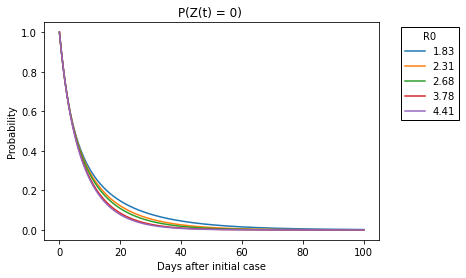

In [57]:
# Solve ODEs 

rho_mat = np.zeros((len(Reff_vec), len(time)))
q_mat = np.zeros_like(rho_mat)
R_vec = np.zeros_like(Reff_vec)
showplot_rho = 1000
for r, Reff in enumerate(Reff_vec):
    beta_SA = Reff*gamma*rtrans_variant
#     beta_vec = beta_SA * prop_vec
    RV = Reff*rtrans_variant

    
    omega_vec = sigma * np.ones(ntypes)              
    
    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
        
    def omega(t): # Return vector of lifetimes for each state
        return omega_vec

#     beta_vec = beta_SA*np.ones(nexposed)
#     for i in range(0, len(vaccine_vec)):
#         beta_vec[2*i:2*i+2]*= vaccine_vec[i]
    
    def P(u, t): # Offspring distribution

        pvec = np.zeros_like(u)
        nexposed = int(ntypes/2)
        omega = (np.sum(prop_vec * const_vec * beta_SA) + gamma)
#         sum_gen_funcs = np.sum((beta_SA*prop_vec/omega)*const_vec*(1+(1/k)*(1-u[:nexposed]))**(-k))
        sum_gen_funcs = np.sum((beta_SA*prop_vec/omega)*const_vec*u[:nexposed])


        for nex in range(0, nexposed):
            pvec[nex] = u[nex+nexposed] 
            pvec[nex+nexposed] =  u[nex+nexposed] * sum_gen_funcs + (gamma/omega)
        return pvec            
            
            
    def eta(t):
        return im_vec.astype(float)
    ics = np.zeros(ntypes+1)
    ics[-1] = 1.
    n0vec = np.zeros(ntypes)
#     n0vec[0] = 1


    offspring = P
    outbreak = MTBP_extinct(offspring)
    outbreak.set_lifespans(omega)
    outbreak.set_immigration(eta)
    rho = outbreak.solve_odes(outbreak.set_odes, time, ics, n0vec, Full = True) # Solve ODEs for probabilities of extinction/zero
    q_mat [r, :] = rho[0, :]
    rho_mat[r, :] = rho[-1, :] # Take 0th row for qs, -1th row for rs

    plt.plot(time[:showplot_rho], rho_mat[r, :showplot_rho], label = str(np.round(RV, 2)))

plt.title("P(Z(t) = 0) " )
plt.xlabel("Days after initial case")
plt.ylabel("Probability")
# plt.savefig("./pnocases_im=" + str(im) + "_beta=" + str(Reff_vec[0]*gamma*rtrans_variant)+ "_n0=0.pdf")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")
# plt.plot(time[:showplot_rho], np.exp(-1/5*time[:showplot_rho]), color = 'black')

In [59]:
rstars = np.zeros(len(Reff_vec))
tol = 0.0001
for r, Reff in enumerate(Reff_vec):
    rstar_idx  = np.min(np.where(np.abs(np.diff(rho_mat[r, :])) <= tol)[0])
    rstar = time[rstar_idx]
    rstars[r] = rstar
rstars

array([56.25625626, 48.84884885, 45.44544545, 40.34034034, 38.83883884])

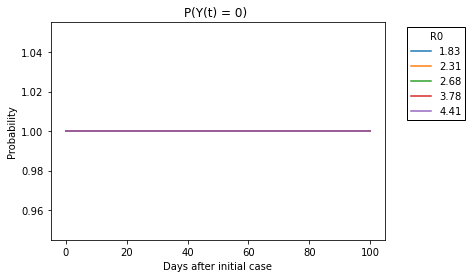

In [7]:
# Equivalent probabilities for a single lineage - no immigration

for r, Reff in enumerate(Reff_vec):
    RV = Reff*rtrans_variant
    plt.plot(time[:showplot_rho], q_mat[r, :showplot_rho], label = str(np.round(RV, 2)))

plt.title("P(Y(t) = 0) ") # Y(t) is process for an individual lineage to go extinct without immigration
plt.xlabel("Days after initial case")
plt.ylabel("Probability")
# plt.savefig("./pnocases_R0=" + str(RV) + ".pdf")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")

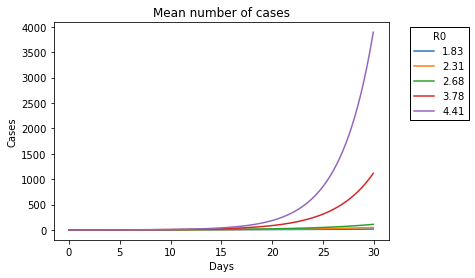

In [80]:
# Mean over time 
mean_cond = np.zeros((len(Reff_vec), len(time)))
mean_arr = np.zeros((len(Reff_vec), ntypes, len(time)))
mean = np.zeros_like(mean_cond)
showplot = 300
for r, Reff in enumerate(Reff_vec):
    beta_SA = Reff*gamma*rtrans_variant
    RV = Reff*rtrans_variant
    
    def Omega(t): # Matrix of first partial derivatives of offspring distribution minus lifetimes*identity
            Omat = np.zeros((ntypes, ntypes))
            omega_vec = sigma * np.ones(ntypes)       

            for nex in range(0, nexposed):
                omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
                Omat[nex, nex+nexposed] = omega_vec[nex]
                Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA 
                Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

            Omat -= np.diag(omega_vec)

            return Omat
    outbreak.set_Omega(Omega)
    n0s = np.zeros(ntypes)
#     n0s[0] = 1.
    Mvec = outbreak.solve_mean_odes(outbreak.set_mean_odes, time, n0s)
    mean_arr[r, :, :] = Mvec
#     mean_cond[r, :] = np.sum(Mvec, axis=0)

#     mean_cond[r, :] = np.sum(Mvec/(1-rho_mat[r, :] + np.finfo(float).eps), axis=0)
    mean[r, :] = np.sum(Mvec, axis=0)
    plt.plot(time[:showplot], mean[r, :showplot], label = str(np.round(RV, 2)))
plt.title("Mean number of cases" )
plt.xlabel("Days")
plt.ylabel("Cases")
# plt.savefig("./meancases_im=" + str(im) + "_R0=" + str(RV)+ "_n0=0.pdf")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")


In [62]:
tstars = np.zeros(len(Reff_vec))
mean_stars = np.zeros((len(Reff_vec), ntypes))
Istar = 100
for r, Reff in enumerate(Reff_vec):
    if mean[r, -1]>=Istar:
        tstar_idx  = np.min(np.where(mean[r, :] >= Istar)[0])
        tstar = time[tstar_idx]
        mean_stars[r, :] = mean_arr[r, :, tstar_idx]
    else:
        tstar = np.nan
    tstars[r] = tstar
tstars

array([52.85285285,         nan,         nan,         nan,         nan])

In [63]:
tstep = int(num/10)
rho_10days = np.append(rho_mat[0, ::tstep], rho_mat[0, -1])
rho_10days

array([1.        , 0.30658869, 0.14650198, 0.07924015, 0.04495123,
       0.02604234, 0.01523724, 0.00895777, 0.00527846, 0.00311392,
       0.00184776])

In [64]:
mean_10days = np.append(mean_arr[0, :, ::tstep], np.reshape(mean_arr[0, :, -1], (16, 1)), axis=1)
np.sum(mean_10days, axis=0)
mean_df = pd.DataFrame(np.vstack((mean_10days, np.atleast_2d(np.sum(mean_10days, axis=0)))))
mean_df

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.684229,2.035251,4.885399,10.898219,23.583181,50.344042,106.800161,225.902954,477.168460,999.756033
1,0.0,0.133221,0.396267,0.951197,2.121905,4.591692,9.802085,20.794204,43.983754,92.905647,194.654486
2,0.0,0.386388,1.149318,2.758813,6.154288,13.317561,28.429577,60.310679,127.568727,269.459836,564.568113
3,0.0,0.083590,0.248638,0.596829,1.331391,2.881062,6.150328,13.047343,27.597650,58.293739,122.136148
4,0.0,0.114038,0.339209,0.814233,1.816370,3.930530,8.390674,17.800027,37.650492,79.528077,166.626005
5,0.0,0.037006,0.110074,0.264221,0.589418,1.275470,2.722801,5.776168,12.217709,25.807124,54.070691
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.0,0.369708,1.223717,3.025412,6.826362,14.845047,31.761684,67.449911,142.739668,301.574895,631.923920
9,0.0,0.071983,0.238260,0.589054,1.329106,2.890360,6.184063,13.132632,27.791697,58.717231,123.036843


In [17]:
# np.savetxt("sd_10days.csv", sig_10days, delimiter = ",")
# np.savetxt("var_10days.csv", var_10days, delimiter = ",")
mean_df.to_csv("./mean_10days_im=" + str(im) + "_beta=" + str(beta_SA)+ "_n0=0.csv")
np.savetxt("./rho_10days_im=" + str(im) + "_beta=" + str(beta_SA)+ "_n0=0.csv", rho_10days, delimiter = ",")

# plt.savefig("./sd_over_mean_plot.pdf")

In [16]:
np.reshape(mean_arr[0, :, -1], (16, 1)).shape

(16, 1)

In [17]:
np.max(rho_mat[r, :] + np.finfo(float).eps)

1.0000000000000002

In [ ]:
def H_mat(t, beta): # Hessian of the Offspring Distribution 

    Hmat = np.zeros((ntypes, ntypes, ntypes))
    omega_vec = sigma * np.ones(ntypes)
    for level in range(0, nexposed):
        omega_vec[level + nexposed] = np.sum(const_vec*prop_vec*beta) + gamma
        for i in range(0, nexposed):
            
#             Hmat[level + nexposed, i, i] =  (const_vec[i]*beta_SA*prop_vec[i])/(omega_vec[level+nexposed])
            Hmat[level + nexposed, level+nexposed, i] = (beta * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])
            Hmat[level + nexposed, i, level+nexposed] = (beta * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])
    
    return Hmat

def P_vecs(t, beta): # Essentially the same as Omega matrix - matrix of partial derivatives - columns should be partial derivatives of each P_i(s)

    Omat = np.zeros((ntypes, ntypes))
    omega_vec = sigma * np.ones(ntypes)
    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta) + gamma
        Omat[nex + nexposed, nex] = 1
        Omat[nex+nexposed, :nexposed] =  (const_vec*beta*prop_vec)/omega_vec[nex+nexposed] 
        Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta*prop_vec)/omega_vec[nex+nexposed] 
    
    return Omat


In [ ]:
def Deltamat(t, immigration, eigvls):
    Delta = np.zeros(ntypes**2)
    eigs = eigvls.copy()
    for j in range(0, ntypes):
        for n in range(0, ntypes):
            Delta[j*ntypes + n] =  (1-np.exp((eigs[j] + eigs[n])*t))/(-eigs[j] - eigs[n])
    Deltamat = np.diag(Delta)
    return Deltamat


def Deltamat_im(t, immigration, eigvls):
    Delta = np.zeros(ntypes**3)
    eigs = eigvls.copy()
    for l in range(0, ntypes):
        for j in range(0, ntypes):
            for n in range(0, ntypes):
                Delta[l*ntypes*ntypes + j*ntypes + n] = (1/(eigs[l] - (eigs[j] + eigs[n])))*((np.exp(eigs[l]*t) - 1)/(eigs[l]) - (np.exp((eigs[j] + eigs[n])*t) - 1)/(eigs[j] + eigs[n]))
                
    Deltamat = np.diag(Delta)
    return Deltamat

In [65]:
# Variance  - for highest R0 (or single value to be chosen)
# Build a vector C from matrix G as in Garden of BPs 
# Reff_vec = np.linspace(1.22, 2.94, num=20)
var_vec = np.zeros((len(Reff_vec), len(time)))
lamb_vec = np.zeros(len(Reff_vec)) # Vector of growth rates for each R0

for r in range(0, len(Reff_vec)):
    Reff = Reff_vec[r]
    beta_SA = Reff*gamma*rtrans_variant
    RV = Reff*rtrans_variant
    tol = 14
    def Omega(t): # Matrix of first partial derivatives of offspring distribution minus lifetimes*identity
                Omat = np.zeros((ntypes, ntypes))
                omega_vec = sigma * np.ones(ntypes)       
                for nex in range(0, nexposed):
                    omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
                    Omat[nex, nex+nexposed] = omega_vec[nex]
                    Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA 
                    Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

                Omat -= np.diag(omega_vec)

                return Omat

    # Diagonalise Omega and find H as in Garden of BPs paper

    eigvls, orth = nla.eig(Omega(0))
    orth = orth
    lamb = np.max(eigvls)
    diagmat = np.real_if_close(np.diag(eigvls))
    orth_inv = np.round(nla.inv(orth), tol)
    orth_c = orth.copy().conjugate()
    orthc_inv = nla.inv(orth_c)
    H = np.kron(orth, np.kron((orthc_inv), orthc_inv))
    # H[6*ntypes*ntypes:(8)*ntypes*ntypes, 6*ntypes*ntypes:(8)*ntypes*ntypes] = 0
    Hinv = np.kron(orth_inv, np.kron(orth_c, orth_c))

    # Hinv = nla.inv(H)

    def H_mat(t, beta): # Hessian of the Offspring Distribution 

        Hmat = np.zeros((ntypes, ntypes, ntypes))
        omega_vec = sigma * np.ones(ntypes)
        for level in range(0, nexposed):
            omega_vec[level + nexposed] = np.sum(const_vec*prop_vec*beta) + gamma
            for i in range(0, nexposed):

    #             Hmat[level + nexposed, i, i] =  (const_vec[i]*beta_SA*prop_vec[i])/(omega_vec[level+nexposed])
                Hmat[level + nexposed, level+nexposed, i] = (beta * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])
                Hmat[level + nexposed, i, level+nexposed] = (beta * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])

        return Hmat

    def P_vecs(t, beta): # Essentially the same as Omega matrix - matrix of partial derivatives - columns should be partial derivatives of each P_i(s)

        Omat = np.zeros((ntypes, ntypes))
        omega_vec = sigma * np.ones(ntypes)
        for nex in range(0, nexposed):
            omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta) + gamma
            Omat[nex + nexposed, nex] = 1
            Omat[nex+nexposed, :nexposed] =  (const_vec*beta*prop_vec)/omega_vec[nex+nexposed] 
            Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta*prop_vec)/omega_vec[nex+nexposed] 

        return Omat


    # Compose Gmat

    Gmat = np.zeros((ntypes, ntypes, ntypes))
    C = np.zeros(ntypes**3)
    omega_vec = sigma * np.ones(ntypes)
    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
    for l in range(0, ntypes):

        Gmat[l, :, :] = H_mat(0, beta_SA)[l, :, :] + np.diag(P_vecs(0, beta_SA)[:, l]) - np.outer(P_vecs(0, beta_SA)[:, l], P_vecs(0, beta_SA)[:, l])
        unitvec = np.zeros(ntypes)
        unitvec[l] = 1
        Gmat[l, :, :] += np.outer(unitvec, unitvec) + np.outer(P_vecs(0, beta_SA)[:, l], P_vecs(0, beta_SA)[:, l]) - np.outer(unitvec, P_vecs(0, beta_SA)[:, l]) - np.outer(P_vecs(0, beta_SA)[:, l], unitvec)
        Gmat[l, :, :] *= omega_vec[l]
        C[l*ntypes*ntypes:(l+1)*ntypes*ntypes] = Gmat[l, :, :].flatten('F') # Stack columns for 'vec' operator

    Amat = np.kron(nla.inv(orth.conjugate()), nla.inv(orth.conjugate()))
    vec_w = np.zeros(ntypes**3)
    Amat_inv = nla.inv(Amat)

    HinvC = nla.solve(H, C)

    def Deltamat(t, immigration, eigvls, l):
        Delta = np.zeros(ntypes**2)
        eigs = eigvls.copy()
        for j in range(0, ntypes):
            for n in range(0, ntypes):
                Delta[j*ntypes + n] =  immigration[l]*(1-np.exp((eigs[j] + eigs[n])*t))/(-eigs[j] - eigs[n])
        Deltamat = np.diag(Delta)
        return Deltamat


    def Deltamat_im(t, immigration, eigvls):
        Delta = np.zeros(ntypes**3)
        eigs = eigvls.copy()
        for l in range(0, ntypes):
            for j in range(0, ntypes):
                for n in range(0, ntypes):
                    Delta[l*ntypes*ntypes + j*ntypes + n] =  (1/(eigs[l] - (eigs[j] + eigs[n])))*((np.exp(eigs[l]*t) - 1)/(eigs[l]) - (np.exp((eigs[j] + eigs[n])*t) - 1)/(eigs[j] + eigs[n]))
    #                 Delta[l*ntypes*ntypes + j*ntypes + n] =  (1/(eigs[l] - (eigs[j] + eigs[n])))*((np.exp(eigs[l]*t) - 1)/(eigs[l]) - (np.exp((eigs[j] + eigs[n])*t) - 1)/(eigs[j] + eigs[n]))

        Deltamat = np.diag(Delta)
        return Deltamat

    # Build both components for variance with immigration from eq. 21 and final eq. on p.213
    def var(t):
        Amat = np.kron(nla.inv(orth_c.copy()), nla.inv(orth_c.copy()))
        vec_w = np.zeros(ntypes**3)
        Amat_inv = nla.inv(Amat.copy())
        vecvar =  H @ Deltamat_im(t, im_vec, eigvls) @ HinvC

        for i in range(0, ntypes):
            unitvec = np.zeros(ntypes)
            unitvec[i] = 1.
            unit_outer_prod = np.outer(unitvec, unitvec).flatten('F') # Stack columns for 'vec' operator
            vec_wi =  Amat @ ( Deltamat(t, im_vec, eigvls, i)) @ Amat_inv @unit_outer_prod
            vec_w[i*ntypes*ntypes:(i+1)*ntypes*ntypes] = vec_wi
            vecvar[i*ntypes*ntypes:(i+1)*ntypes*ntypes] *=im_vec[i]



    #     vecvar =  H @ Deltamat_im(t, im_vec, eigvls) @ HinvC
        var_im = np.reshape(vecvar, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)
        w = np.reshape(vec_w, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)

        var_im += w
        return var_im  # np.reshape(vec_w, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)





    # varmat = np.sum(var(30), axis=0) # Sum variance for all different types into total variance matrix
    
    T=0
    for Time in tqdm(time):
        var_vec[r, T] = np.sum(var(Time))
        T+=1



100%|██████████| 1000/1000 [11:48<00:00,  1.41it/s]


<ipython-input-99-957294a30ebf>:4: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
<ipython-input-99-957294a30ebf>:4: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
<ipython-input-99-957294a30ebf>:4: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
<ipython-input-99-957294a30ebf>:4: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
<ipython-input-99-957294a30ebf>:4: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
<ipython-input-99-957294a30ebf>:18: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :])/(mean[r, :])
<ipython-input-99-957294a30ebf>:20: RuntimeWarning: invalid value encountered in less_equal
  Tstar_idx[r] = (np.min(np.where(np.abs(diff[1:])<=tol)[0]))


Text(0, 0.5, 'Days')

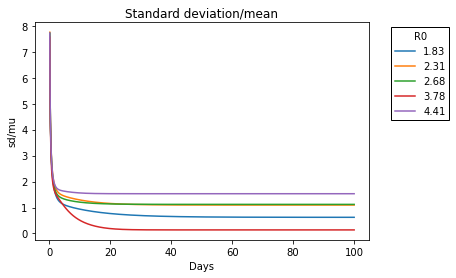

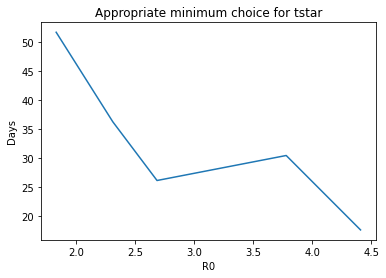

In [99]:
sig_vec= np.sqrt(var_vec)
for r in range(0, len(Reff_vec)):
    RV = np.round(Reff_vec[r]*rtrans_variant, 2)
    sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
#     sig_over_mean = (sig_vec[r, :]/(mean_cond[r, :] ))
    plt.plot(time ,sig_over_mean , label = str(RV))
plt.title("Standard deviation/mean")
plt.ylabel("sd/mu")
plt.xlabel("Days")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")
# plt.savefig("./sd_over_mean_plot.pdf")


tol = 1e-4
Tstars = np.zeros(len(Reff_vec))
Tstar_idx = np.zeros(len(Reff_vec)).astype(int)
for r in range(0, len(Reff_vec)):
    sig_over_mean = (sig_vec[r, :])/(mean[r, :])
    diff = np.gradient(sig_over_mean)
    Tstar_idx[r] = (np.min(np.where(np.abs(diff[1:])<=tol)[0]))
    Tstars[r] = time[Tstar_idx[r]]
plt.figure()
plt.plot(Reff_vec*rtrans_variant, Tstars)
plt.title("Appropriate minimum choice for tstar")
plt.xlabel("R0")
plt.ylabel("Days")
# plt.savefig("./tstarchoice.pdf")

<ipython-input-153-6ced9aa8500e>:39: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot]), color = color, label = "sd/mean")
<ipython-input-153-6ced9aa8500e>:43: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot]), color = color)
<ipython-input-153-6ced9aa8500e>:43: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot]), color = color)
<ipython-input-153-6ced9aa8500e>:43: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot]), color = color)
<ipython-input-153-6ced9aa8500e>:43: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot]), color = color)


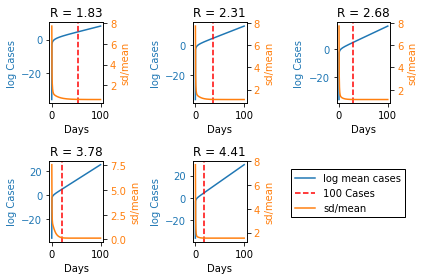

In [153]:
np.hstack((Tstars, tstars))
Tstar_idx
time[Tstar_idx]
threshold = 100
Istars_min = np.zeros_like(Tstar_idx)
tst_idx = np.zeros_like(Tstar_idx)
for r in range(0, len(Reff_vec)):
    Istars_min[r] = mean[r, Tstar_idx[r]]
    tst_idx[r] = np.min(np.where(mean[r, :]>=threshold))
Istars_min
Tstar_idx

showplot = int(len(time))

fig, axs = plt.subplots(2, 3)
for r in range(0, len(Reff_vec)):
    RV = np.round(Reff_vec[r]*rtrans_variant, 2)
    if r<=2:
        b = 0
    else:
        b=1    
    color = 'tab:blue'
    if r ==0:
        
        axs[b, r%3].plot(time[:showplot], np.log(mean[r, :showplot] + np.finfo(float).eps) , color = color, label = "log mean cases")
    else:
        axs[b, r%3].plot(time[:showplot], np.log(mean[r, :showplot] + np.finfo(float).eps) , color = color)
        axs[b, r%3].axvline(time[tst_idx[r]], color = 'r', linestyle = '--')
    axs[b, r%3].tick_params(axis='y', labelcolor=color)
    
    axs[b, r%3].set_ylabel("log Cases", color = color)
    axs[b, r%3].set_ylabel("log Cases", color = color)
    axs[b, r%3].set_xlabel("Days")
    axs[b, r%3].set_title("R = " + str(RV))
    axs[-1, -1].set_visible(False)
    color= 'tab:orange'
    ax1 = axs[b, r%3].twinx()
    if r ==0:
        ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot]), color = color, label = "sd/mean")
        axs[b, r%3].axvline(time[tst_idx[r]], color = 'r', linestyle = '--', label = str(threshold) + " Cases")

    else:
        ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot]), color = color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylabel("sd/mean", color = color)
    
    
    
bottom_right_ax = axs[-1][-1] 
# color = 'tab:blue'
# bottom_right_ax.plot(time[:showplot], np.log(mean[r, :showplot] + np.finfo(float).eps) , color = color, label = "log mean cases")
# color = 'tab:orange'
# bottom_right_ax.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot]), color = color, label = "standard deviation/mean")
# bottom_right_ax.axvline(time[tst_idx[r]], color = 'r', linestyle = '--', label = str(threshold) + " Cases")
bottom_right_ax.clear()  # clears the random data I plotted previously
bottom_right_ax.set_axis_off()
fig.legend(loc='lower right', bbox_to_anchor=(0.95, 0.2),framealpha=1., edgecolor='black', fancybox=False)

fig.tight_layout()
# plt.show()
plt.savefig("./sig_over_mean_comparison.pdf")

In [ ]:

var_10days = np.append(var_vec[::100], var_vec[-1])
sig_10days = np.sqrt(var_10days)


In [ ]:
np.sqrt(np.sum(varmat)) # Standard deviation for sum of particle counts

In [555]:
Reff = Reff_vec[0]
beta_SA = Reff*gamma*rtrans_variant
RV = Reff*rtrans_variant
rounding = 14
def Omega(t): # Matrix of first partial derivatives of offspring distribution minus lifetimes*identity
            Omat = np.zeros((ntypes, ntypes))
            omega_vec = sigma * np.ones(ntypes) 
#             omega_vec[6:8] = 0
            for nex in range(0, nexposed):
                omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
                Omat[nex, nex+nexposed] = omega_vec[nex]
                Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA 
                Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

            Omat -= np.diag(omega_vec)

            return Omat

# Diagonalise Omega and find H as in Garden of BPs paper

eigvls, orth = nla.eig(Omega(0))
orth = orth
lamb = np.max(eigvls)
diagmat = np.real_if_close(np.diag(eigvls))
orth_inv = nla.inv(orth)
orth_c = orth.copy().conjugate()
orthc_inv = nla.inv(orth_c)
H = np.kron(orth, np.kron((orthc_inv), orthc_inv))
# H[6*ntypes*ntypes:(8)*ntypes*ntypes, 6*ntypes*ntypes:(8)*ntypes*ntypes] = 0
Hinv = np.kron(orth_inv, np.kron(orth_c, orth_c))

# Hinv = nla.inv(H)

def H_mat(t, beta): # Hessian of the Offspring Distribution 

    Hmat = np.zeros((ntypes, ntypes, ntypes))
    omega_vec = sigma * np.ones(ntypes)
#     omega_vec[6:8] = 0

    for level in range(0, nexposed):
        omega_vec[level + nexposed] = np.sum(const_vec*prop_vec*beta) + gamma
        for i in range(0, nexposed):
            
#             Hmat[level + nexposed, i, i] =  (const_vec[i]*beta_SA*prop_vec[i])/(omega_vec[level+nexposed])
            Hmat[level + nexposed, level+nexposed, i] = (beta * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])
            Hmat[level + nexposed, i, level+nexposed] = (beta * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])
    
    return Hmat

def P_vecs(t, beta): # Essentially the same as Omega matrix - matrix of partial derivatives - columns should be partial derivatives of each P_i(s)

    Omat = np.zeros((ntypes, ntypes))
    omega_vec = sigma * np.ones(ntypes)
    omega_vec[6:8] = 0

    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta) + gamma
        Omat[nex + nexposed, nex] = 1
        Omat[nex+nexposed, :nexposed] =  (const_vec*beta*prop_vec)/omega_vec[nex+nexposed] 
        Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta*prop_vec)/omega_vec[nex+nexposed] 
    
    return Omat


# Compose Gmat

Gmat = np.zeros((ntypes, ntypes, ntypes))
C = np.zeros(ntypes**3)
omega_vec = sigma * np.ones(ntypes)

# omega_vec[6:8] = 0

for nex in range(0, nexposed):
    omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
for l in range(0, ntypes):

    Gmat[l, :, :] = H_mat(0, beta_SA)[l, :, :] + np.diag(P_vecs(0, beta_SA)[:, l]) - np.outer(P_vecs(0, beta_SA)[:, l], P_vecs(0, beta_SA)[:, l])
    unitvec = np.zeros(ntypes)
    unitvec[l] = 1
    Gmat[l, :, :] += np.outer(unitvec, unitvec) + np.outer(P_vecs(0, beta_SA)[:, l], P_vecs(0, beta_SA)[:, l]) - np.outer(unitvec, P_vecs(0, beta_SA)[:, l]) - np.outer(P_vecs(0, beta_SA)[:, l], unitvec)
    Gmat[l, :, :] *= omega_vec[l]
    C[l*ntypes*ntypes:(l+1)*ntypes*ntypes] = Gmat[l, :, :].flatten('F') # Stack columns for 'vec' operator

Amat = np.kron(nla.inv(orth.conjugate()), nla.inv(orth.conjugate()))
vec_w = np.zeros(ntypes**3)
Amat_inv = nla.inv(Amat)

HinvC = nla.solve(H, C)

def Deltamat(t, immigration, eigvls, l):
    Delta = np.zeros(ntypes**2)
    eigs = eigvls.copy()
    for j in range(0, ntypes):
        for n in range(0, ntypes):
            Delta[j*ntypes + n] =  immigration[l]*(1-np.exp((eigs[j] + eigs[n])*t))/(-eigs[j] - eigs[n])
    Deltamat = np.diag(Delta)
    return Deltamat


def Deltamat_im(t, immigration, eigvls):
    Delta = np.zeros(ntypes**3)
    eigs = eigvls.copy()
    for l in range(0, ntypes):
        for j in range(0, ntypes):
            for n in range(0, ntypes):
                Delta[l*ntypes*ntypes + j*ntypes + n] =  (1/(eigs[l] - (eigs[j] + eigs[n])))*((np.exp(eigs[l]*t) - 1)/(eigs[l]) - (np.exp((eigs[j] + eigs[n])*t) - 1)/(eigs[j] + eigs[n]))
#                 Delta[l*ntypes*ntypes + j*ntypes + n] =  (1/(eigs[l] - (eigs[j] + eigs[n])))*((np.exp(eigs[l]*t) - 1)/(eigs[l]) - (np.exp((eigs[j] + eigs[n])*t) - 1)/(eigs[j] + eigs[n]))
                
    Deltamat = np.diag(Delta)
    return Deltamat

# Build both components for variance with immigration from eq. 21 and final eq. on p.213
def var(t):
    Amat = np.kron(nla.inv(orth_c.copy()), nla.inv(orth_c.copy()))
    vec_w = np.zeros(ntypes**3)
    Amat_inv = nla.inv(Amat.copy())
    vecvar =  H @ Deltamat_im(t, im_vec, eigvls) @ HinvC

    for i in range(0, ntypes):
        unitvec = np.zeros(ntypes)
        unitvec[i] = 1.
        unit_outer_prod = np.outer(unitvec, unitvec).flatten('F') # Stack columns for 'vec' operator
        vec_wi =  Amat @ ( Deltamat(t, im_vec, eigvls, i)) @ Amat_inv @unit_outer_prod
        vec_w[i*ntypes*ntypes:(i+1)*ntypes*ntypes] = vec_wi
        vecvar[i*ntypes*ntypes:(i+1)*ntypes*ntypes] *=im_vec[i]

    
    
#     vecvar =  H @ Deltamat_im(t, im_vec, eigvls) @ HinvC
    var_im = np.reshape(vecvar, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)
    w = np.reshape(vec_w, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)
    
    var_im += w
    return var_im  # np.reshape(vec_w, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)






In [506]:
pd.DataFrame(Omega(0)@orth - orth@diagmat)
l=6
grape = (H @ Deltamat_im(tstars[0], im_vec, eigvls) @ Hinv)[l*ntypes*ntypes:(l+1)*ntypes*ntypes]
grape.shape
Deltamat_im(tstars[0], im_vec, eigvls)[3007, 3007]
#3007

<ipython-input-502-d7aedaa7d956>:99: RuntimeWarning: divide by zero encountered in double_scalars
  Delta[l*ntypes*ntypes + j*ntypes + n] =  (1/(eigs[l] - (eigs[j] + eigs[n])))*((np.exp(eigs[l]*t) - 1)/(eigs[l]) - (np.exp((eigs[j] + eigs[n])*t) - 1)/(eigs[j] + eigs[n]))
<ipython-input-502-d7aedaa7d956>:99: RuntimeWarning: invalid value encountered in double_scalars
  Delta[l*ntypes*ntypes + j*ntypes + n] =  (1/(eigs[l] - (eigs[j] + eigs[n])))*((np.exp(eigs[l]*t) - 1)/(eigs[l]) - (np.exp((eigs[j] + eigs[n])*t) - 1)/(eigs[j] + eigs[n]))


nan

In [557]:
vartest = var(tstars[0])
bananavar = np.zeros(ntypes)
newlevels = [6, 7, 14, 15]
for i in range(0, ntypes):

    bananavar[i] +=np.sum(vartest[i])
bananavar
# np.savetxt("./Omega.csv", Omega(0), delimiter = ",")
# np.savetxt("./eigvls.csv", eigvls, delimiter = ",")

# pear = np.diagonal(Deltamat_im(tstars[0], im_vec, eigvls))
l = 6
# pear[l*ntypes*ntypes:(l+1)*ntypes*ntypes]
# np.max(H[l*ntypes*ntypes:(l+1)*ntypes*ntypes, l*ntypes*ntypes:(l+1)*ntypes*ntypes])
bananavar
# C[(l+1)*ntypes*ntypes:(l+2)*ntypes*ntypes] - C[(l+2)*ntypes*ntypes:(l+3)*ntypes*ntypes]
pear = Deltamat_im(tstars[0], im_vec, eigvls)
l = 6+1
# np.max(((H ))[l*ntypes*ntypes:(l+1)*ntypes*ntypes])# @ Hinv @C[l*ntypes*ntypes:(l+1)*ntypes*ntypes]

np.diagonal(pear)[l*ntypes*ntypes:(l+1)*ntypes*ntypes]
# np.sqrt(bananavar)/mean_arr[0, :, 54]
bananavar
       



<ipython-input-555-354d71254ab1>:106: RuntimeWarning: divide by zero encountered in double_scalars
  Delta[l*ntypes*ntypes + j*ntypes + n] =  (1/(eigs[l] - (eigs[j] + eigs[n])))*((np.exp(eigs[l]*t) - 1)/(eigs[l]) - (np.exp((eigs[j] + eigs[n])*t) - 1)/(eigs[j] + eigs[n]))
<ipython-input-555-354d71254ab1>:106: RuntimeWarning: invalid value encountered in double_scalars
  Delta[l*ntypes*ntypes + j*ntypes + n] =  (1/(eigs[l] - (eigs[j] + eigs[n])))*((np.exp(eigs[l]*t) - 1)/(eigs[l]) - (np.exp((eigs[j] + eigs[n])*t) - 1)/(eigs[j] + eigs[n]))
<ipython-input-555-354d71254ab1>:95: RuntimeWarning: invalid value encountered in double_scalars
  Delta[j*ntypes + n] =  immigration[l]*(1-np.exp((eigs[j] + eigs[n])*t))/(-eigs[j] - eigs[n])


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan])

DescribeResult(nobs=10000, minmax=(2.5232899241823574, 768.5710664836611), mean=53.13010138697867, variance=3157.893484222087, skewness=3.2905847673920996, kurtosis=18.68310636210258)

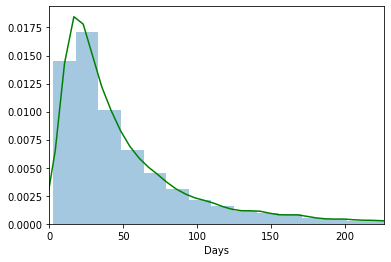

In [473]:
t_idx = np.min(np.where(time == tstars[0])[0])
varnew = np.sum(var(tstars[0]))
# variance = np.sum(bananavar[:6]) + np.sum(bananavar[9:])
sd = np.sqrt(varnew)

nu = np.log(Istar)

wald = np.random.wald(tstars[0], nu**2/((sd/(Istar))**2), size=10000)
df = pd.Series(wald, name = "Days")

sns.distplot(df, kde_kws={"color": "g"})
plt.xlim(0, np.quantile(wald, 1-0.025)+20)



# normal = np.random.normal(nu, nu**2/((sd/(Istar))**2), size=10000)
# dfnu = pd.Series(normal, name = "Days")
# sns.distplot(dfnu, kde_kws={"color": "g"})


# plt.savefig("./time_distplot_R0=" + str(RV) + ".pdf")
# plt.savefig("./time_distplot_alternative_R0=" + str(RV) + ".pdf")
sp.stats.describe(wald)


In [465]:
sp.stats.mode(wald)

ModeResult(mode=array([2.93832268]), count=array([1]))

In [334]:
t_idx = np.min(np.where(time == tstars[0])[0])
variance = var_vec[0, t_idx]
sd = np.sqrt(variance)
nu = np.log(Istar)
# wald = np.random.wald(nu/lamb, nu**2/(sd/(100))**2, size=10000)
wald = np.random.wald(tstars[0], nu**2/(sd/(Istar))**2, size=10000)
df = pd.Series(wald, name = "Days")
sns.distplot(df, kde_kws={"color": "g"})

# plt.savefig("./time_distplot_R0=" + str(RV) + ".pdf")
# plt.savefig("./time_distplot_alternative_R0=" + str(RV) + ".pdf")
sp.stats.describe(wald)

NameError: name 'var_vec' is not defined

In [ ]:
# Reff = Reff_vec[0]
# beta_SA = Reff*gamma*rtrans_variant
# RV = Reff*rtrans_variant
# def Omega(t): # Matrix of first partial derivatives of offspring distribution minus lifetimes*identity
#     Omat = np.zeros((ntypes, ntypes))
#     omega_vec = sigma * np.ones(ntypes)       

#     for nex in range(0, nexposed):
#         omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
#         Omat[nex, nex+nexposed] = omega_vec[nex]
#         Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA 
#         Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

#     Omat -= np.diag(omega_vec)

#     return Omat
# Gmat = np.zeros((ntypes, ntypes, ntypes))
# C = np.zeros(ntypes**3)
# omega_vec = sigma * np.ones(ntypes)
# for nex in range(0, nexposed):
#     omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
# for l in range(0, ntypes):

#     Gmat[l, :, :] = H_mat(0, beta_SA)[l, :, :] + np.diag(P_vecs(0, beta_SA)[:, l]) - np.outer(P_vecs(0, beta_SA)[:, l], P_vecs(0, beta_SA)[:, l])
#     unitvec = np.zeros(ntypes)
#     unitvec[l] = 1
#     Gmat[l, :, :] += np.outer(unitvec, unitvec) + np.outer(P_vecs(0, beta_SA)[:, l], P_vecs(0, beta_SA)[:, l]) - np.outer(unitvec, P_vecs(0, beta_SA)[:, l]) - np.outer(P_vecs(0, beta_SA)[:, l], unitvec)
#     Gmat[l, :, :] *= omega_vec[l]
#     C[l*ntypes*ntypes:(l+1)*ntypes*ntypes] = Gmat[l, :, :].flatten('F') # Stack columns for 'vec' operator

# Amat = np.kron(nla.inv(orth.conjugate()), nla.inv(orth.conjugate()))
# vec_w = np.zeros(ntypes**3)
# Amat_inv = nla.inv(Amat)
# def var(t):
#     for i in range(0, ntypes):
#         unitvec = np.zeros(ntypes)
#         unitvec[i] = 1.
#         unit_outer_prod = np.outer(unitvec, unitvec).flatten('F') # Stack columns for 'vec' operator
#         vec_wi =  Amat @ Deltamat(t, im_vec, eigvls) @ Amat_inv @unit_outer_prod
#         vec_w[i*ntypes*ntypes:(i+1)*ntypes*ntypes] = vec_wi


#     vecvar =  H @ Deltamat_im(t, im_vec, eigvls) @ Hinv @ C + vec_w
#     var = np.reshape(vecvar, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)
#     for i in range(0, ntypes):
#         var[i]*=im_vec[i]

#     return var

# eigvls, orth = nla.eig(Omega(0))
# lamb = np.max(eigvls)
# lamb # This is growth rate 

In [ ]:
np.where(time == tstars[0])[0]

In [ ]:
variance = np.sum(var(tstars[0]))
alpha = tstars[0]
wald = np.random.wald(alpha,variance, size=10000 )
sns.distplot(wald, kde_kws={"color": "g"})
sp.stats.describe(wald)

In [ ]:
alpha**3 * (variance/100**2)

In [ ]:
variance = np.sum(var(np.log(100)/lamb)).real
wald = np.random.wald(np.log(100)/lamb  , (variance/(lamb*100)**2).real, size=10000 )
# wald = np.random.normal(np.log(100)/lamb - variance/(2*(100**2)) , (variance/(lamb*100)**2).real, size=10000 )
# wald = np.random.wald(np.log(100)/lamb , variance/(lamb**2), size=10000 )

sns.distplot(wald, kde_kws={"color": "g"})
sp.stats.describe(wald)

In [ ]:
np.log(100)/lamb

In [ ]:
variance = np.sum(var(tstars[0])).real
t_star = tstars[0]
mean_star = 100
mu_star = np.log(mean_star**2/np.sqrt(mean_star**2 + variance))
# mu_star = np.log(mean_star)/lamb
sig_star = np.log(1 + variance/(mean_star**2))
lognorm = np.random.lognormal(mu_star, sig_star, size=10000)


sns.distplot(lognorm, kde_kws={"color": "g"})
sp.stats.describe(lognorm)

In [ ]:
variance = np.sum(var(tstars[0])).real
alpha = np.log(100)/lamb

time_dist = np.random.normal(alpha, variance/(100**2), size=10000 )
sns.distplot(time_dist, kde_kws={"color": "g"})
sp.stats.describe(time_dist)

In [ ]:
variance = np.sum(var(tstars[0])).real
alpha = np.log(100)

time_dist = np.random.normal(alpha, variance/(100**2), size=10000 )
sns.distplot(time_dist, kde_kws={"color": "g"})
sp.stats.describe(time_dist)
# plt.savefig("./time_distributions_mtbp.pdf")

In [ ]:
import seaborn as sns
ln = np.random.lognormal(4.14, 0.327, size=10000 )
sns.distplot(ln, kde_kws={"color": "g"})
sp.stats.describe(ln)

In [ ]:
np.sum(var(tstars[-1])).real

In [287]:
plum = np.arange(27).reshape(3, 3, 3)
plum1 = plum[0].flatten('F')
plum1
# np.reshape(plum1, (3, 3, 3)).transpose(0, 2, 1)

array([0, 3, 6, 1, 4, 7, 2, 5, 8])

In [254]:
pd.DataFrame(Omega(0) + 0.3*np.identity(ntypes))
# np.where(np.round(eigvls, 3)==-0.3)
# eigvls

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3
8,0.281857,0.054878,0.159166,0.034433,0.046976,0.015244,0.0,0.0,-0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.281857,0.054878,0.159166,0.034433,0.046976,0.015244,0.0,0.0,0.0,-0.1,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

# beta_SA = Reff_vec[0]*gamma*rtrans_variant
# RV = Reff*rtrans_variant
# def Omega(t): # Matrix of first partial derivatives of offspring distribution minus lifetimes*identity
#         Omat = np.zeros((ntypes, ntypes))
#         omega_vec = sigma * np.ones(ntypes)       
        
#         for nex in range(0, nexposed):
#             omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
#             Omat[nex, nex+nexposed] = omega_vec[nex]
#             Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA 
#             Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

#         Omat -= np.diag(omega_vec)
        
#         return Omat

# # Diagonalise Omega and find H as in Garden of BPs paper

# eigvls, orth = nla.eig(Omega(0))
# diagmat = np.real_if_close(np.diag(eigvls))
# H = np.kron(orth, np.kron(nla.inv(orth.conjugate()), nla.inv(orth.conjugate())))
# Hinv = np.kron(nla.inv(orth), np.kron(orth.conjugate(), orth.conjugate()))
# Hinv = nla.inv(H)

# def H_mat(t): # Hessian of the Offspring Distribution 

#     Hmat = np.zeros((ntypes, ntypes, ntypes))
    
#     for level in range(0, nexposed):

#         for i in range(0, nexposed):
            
# #             Hmat[level + nexposed, i, i] =  (const_vec[i]*beta_SA*prop_vec[i])/(omega_vec[level+nexposed])
#             Hmat[level + nexposed, level+nexposed, i] = (beta_SA * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])
#             Hmat[level + nexposed, i, level+nexposed] = (beta_SA * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])
    
#     return Hmat

# def P_vecs(t): # Essentially the same as Omega matrix - matrix of partial derivatives - columns should be partial derivatives of each P_i(s)

#     Omat = np.zeros((ntypes, ntypes))
#     omega_vec = sigma * np.ones(ntypes)
#     for nex in range(0, nexposed):
#         omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
#         Omat[nex + nexposed, nex] = 1
#         Omat[nex+nexposed, :nexposed] =  (const_vec*beta_SA*prop_vec)/omega_vec[nex+nexposed] 
#         Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA*prop_vec)/omega_vec[nex+nexposed] 
    
#     return Omat


# # Build a vector C from matrix G as in Garden of BPs 
# Gmat = np.zeros((ntypes, ntypes, ntypes))
# C = np.zeros(ntypes**3)
# omega_vec = sigma * np.ones(ntypes)
# for nex in range(0, nexposed):
#     omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
# for l in range(0, ntypes):
    
#     Gmat[l, :, :] = H_mat(0)[l, :, :] + np.diag(P_vecs(0)[:, l]) - np.outer(P_vecs(0)[:, l], P_vecs(0)[:, l])
#     unitvec = np.zeros(ntypes)
#     unitvec[l] = 1
#     Gmat[l, :, :] += np.outer(unitvec, unitvec) + np.outer(P_vecs(0)[:, l], P_vecs(0)[:, l]) - np.outer(unitvec, P_vecs(0)[:, l]) - np.outer(P_vecs(0)[:, l], unitvec)
#     Gmat[l, :, :] *= omega_vec[l]
#     C[l*ntypes*ntypes:(l+1)*ntypes*ntypes] = Gmat[l, :, :].flatten('F') # Stack columns for 'vec' operator


# def Deltamat(t, immigration):
#     Delta = np.zeros(ntypes**2)
#     eigs = eigvls.copy()
#     for j in range(0, ntypes):
#         for n in range(0, ntypes):
#             Delta[j*ntypes + n] =  (1-np.exp((eigs[j] + eigs[n])*t))/(-eigs[j] - eigs[n])
#     Deltamat = np.diag(Delta)
#     return Deltamat


# def Deltamat_im(t, immigration):
#     Delta = np.zeros(ntypes**3)
#     eigs = eigvls.copy()
#     for l in range(0, ntypes):
#         for j in range(0, ntypes):
#             for n in range(0, ntypes):
#                 Delta[l*ntypes*ntypes + j*ntypes + n] = (1/(eigs[l] - (eigs[j] + eigs[n])))*((np.exp(eigs[l]*t) - 1)/(eigs[l]) - (np.exp((eigs[j] + eigs[n])*t) - 1)/(eigs[j] + eigs[n]))
                
#     Deltamat = np.diag(Delta)
#     return Deltamat

# def var(t):
#     # Build both components for variance with immigration from eq. 21 and final eq. on p.213
    
#     Amat = np.kron(nla.inv(orth.conjugate()), nla.inv(orth.conjugate()))
#     vec_w = np.zeros(ntypes**3)
#     for i in range(0, ntypes):
#         unitvec = np.zeros(ntypes)
#         unitvec[i] = 1.
#         unit_outer_prod = np.outer(unitvec, unitvec).flatten('F') # Stack columns for 'vec' operator
#         vec_wi =  Amat @ Deltamat(t, im_vec) @ nla.inv(Amat)@unit_outer_prod
#         vec_w[i*ntypes*ntypes:(i+1)*ntypes*ntypes] = vec_wi
    
#     Amat = np.kron(nla.inv(orth.conjugate()), nla.inv(orth.conjugate()))
#     vecvar =  H @ Deltamat_im(t, im_vec) @ Hinv @ C + vec_w
#     var = np.reshape(vecvar, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)
#     for i in range(0, ntypes):
#         var[i]*=im_vec[i]

#     return var